In [ ]:
!pip install kaggle

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 66% 17.0M/25.7M [00:00<00:00, 89.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 99.1MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import re
from bs4 import BeautifulSoup


# Data
import pandas as pd
import numpy as np

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# viz
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

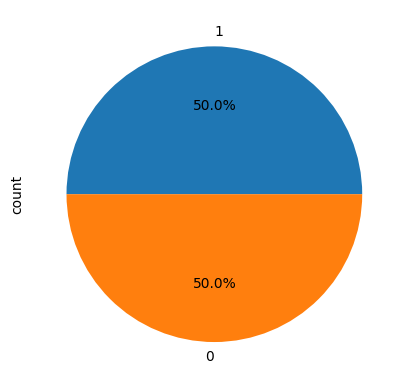

In [ ]:
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [ ]:
# Fonction pour supprimer les éléments HTML
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['review'] = df['review'].apply(remove_html_tags)


<ipython-input-4-532e725e164b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review'] = df['review'].apply(remove_punctuation)

In [ ]:
def lower_case(text):
    return text.lower()

df['review'] = df['review'].apply(lower_case)

In [ ]:
# Stop word
stop_words = set(stopwords.words('english'))

# suppression des stop words.
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['review'] = df['review'].apply(remove_stop_words)

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['review'] = df['review'].apply(lemmatize_text)

In [ ]:
raw_corpus = "".join(df.review.values)

In [ ]:
from collections import Counter

# Combiner toutes les critiques en un seul texte
all_reviews = ' '.join(df['review']).lower()

# Compter la fréquence de chaque mot
words = re.findall(r'\b\w+\b', all_reviews)
word_counts = Counter(words)

# Filtrer les mots qui apparaissent plus de 5 fois
frequent_words = {word for word, count in word_counts.items() if count > 5}

# Fonction pour filtrer les mots dans chaque critique
def filter_review(review, frequent_words):
    words = review.lower().split()
    filtered_words = [word for word in words if word in frequent_words]
    return ' '.join(filtered_words)

# Appliquer la fonction à chaque critique
df['filtered_review'] = df['review'].apply(filter_review, args=(frequent_words,))

In [ ]:
raw_corpus = "".join(df.review.values)
# Diviser le corpus brut en mots individuels
words = raw_corpus.split()

# Utiliser un ensemble pour obtenir les mots uniques
unique_words = set(words)

# Compter le nombre de mots uniques
num_unique_words = len(unique_words)

# Afficher le nombre de mots uniques
print("Nombre de mots uniques dans le corpus brut :", num_unique_words)

Nombre de mots uniques dans le corpus brut : 250551


In [ ]:
raw_corpus = "".join(df.filtered_review.values)
# Diviser le corpus brut en mots individuels
words = raw_corpus.split()

# Utiliser un ensemble pour obtenir les mots uniques
unique_words = set(words)

# Compter le nombre de mots uniques
num_unique_words = len(unique_words)

# Afficher le nombre de mots uniques
print("Nombre de mots uniques dans le corpus brut :", num_unique_words)

Nombre de mots uniques dans le corpus brut : 78532


In [ ]:
raw_corpus = "".join(df.filtered_review.values)

In [ ]:
# tokenize of raw_coprus
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(raw_corpus)

In [ ]:
# Utilisez pad_sequences de Keras pour que toutes les séquences aient la même longueur.
# Préparer les commentaires pour la tokenisation
reviews = df['filtered_review'].tolist()

# Initialiser et adapter le Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

# Convertir les commentaires en séquences de tokens
sequences = tokenizer.texts_to_sequences(reviews)

# Définir la longueur maximale des séquences
max_length = 400

# Appliquer le padding aux séquences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

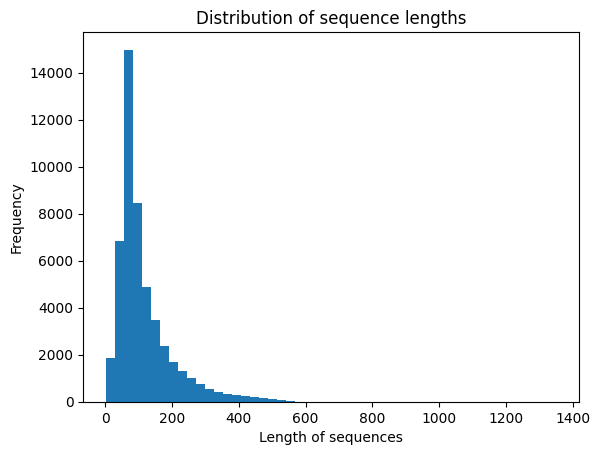

In [ ]:
# Histogramme de la longueur des séquences de mots
seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Length of sequences')
plt.ylabel('Frequency')
plt.title('Distribution of sequence lengths')
plt.show()

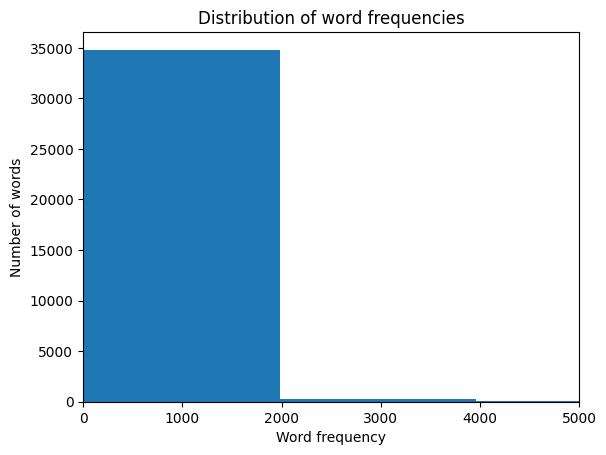

In [ ]:
# Histogramme des fréquences des mots différents
word_counts = tokenizer.word_counts.values()
plt.hist(word_counts, bins=50)
plt.xlabel('Word frequency')
plt.ylabel('Number of words')
plt.title('Distribution of word frequencies')
plt.xlim([0, 5000])
plt.show()

In [ ]:
# Utilisez LabelEncoder de sklearn pour transformer les labels catégoriels en valeurs numériques.
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])

df['sentiment'] = labels

In [ ]:
X = padded_sequences
y = df['sentiment'].values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Définir le callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # La métrique à surveiller
    factor=0.2,            # Facteur par lequel le taux d'apprentissage sera réduit
    patience=5,            # Nombre d'époques avec no amélioration après lesquelles le taux sera réduit
    min_lr=0.001           # Le taux d'apprentissage minimum
)

In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=78532, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')# à vous de voir
])

In [ ]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100


Exception ignored in: <function AtomicFunction.__del__ at 0x7fcf8827db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Utilisez confusion_matrix de sklearn pour calculer la matrice de confusion de chaque modèle sur le jeu de test.
model_lstm.evaluate(X_test, Y_test)

In [ ]:
y_pred = model_lstm.predict(X_test)

In [ ]:
confusion_matrix = confusion_matrix(Y_test, y_pred)

In [ ]:
#  calculez les métriques suivantes : accuracy, precision, f1-score, recall, sensibilité et spécificité. Utilisez les fonctions de sklearn.metrics.
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
sensitivity = recall
specificity = recall

In [ ]:
# Affichez les courbes ROC pour chacun des modèles et calculez l'AUC (Area Under the Curve). Interprétez les résultats obtenus.
roc_curve(Y_test, y_pred)
auc = roc_auc_score(Y_test, y_pred)